In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import seaborn as sns
import shutil
import warnings
warnings.filterwarnings("ignore")
import logging
from tqdm import tqdm


# model
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal
from darts.metrics import rmse, r2_score
from darts.models import NaiveDrift
from darts.models import NaiveEnsembleModel
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, ARIMA
from darts.utils.statistics import plot_residuals_analysis
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
from darts.models import RNNModel
from darts.models.forecasting.prophet_model import Prophet
from darts.models import NBEATSModel
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

# mlflow
!pip install mlflow --q
import mlflow

## data preprocessing

In [61]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True) 

# df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

# split
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

## EDA

In [62]:
df_el['date'] = df_el['date'].astype(str)
df_el[['date', 'time']] = df_el['date'].str.split(' ', expand=True)
df_el[['day', 'month', 'year']] = df_el['date'].str.split('.', expand=True)
df_el['hour'] = df_el['time'].str.split(':', expand=True)[0]

In [63]:
df_el.head()

,date,price,time,day,month,year,hour
0,01.01.2023,2.01,00:00,01,01,2023,00
1,01.01.2023,1.38,01:00,01,01,2023,01
2,01.01.2023,0.09,02:00,01,01,2023,02
3,01.01.2023,0.08,03:00,01,01,2023,03
4,01.01.2023,0.05,04:00,01,01,2023,04


In [64]:
df_el['price'] = df_el['price'].astype(float)
df_el[['hour', 'minute']] = df_el['time'].str.split(':', expand=True)
df_el['hour'] = df_el['hour'].astype(int)
df_el['day'] = df_el['day'].astype(int)
df_el['month'] = df_el['month'].astype(int)


<Axes: xlabel='month', ylabel='price'>

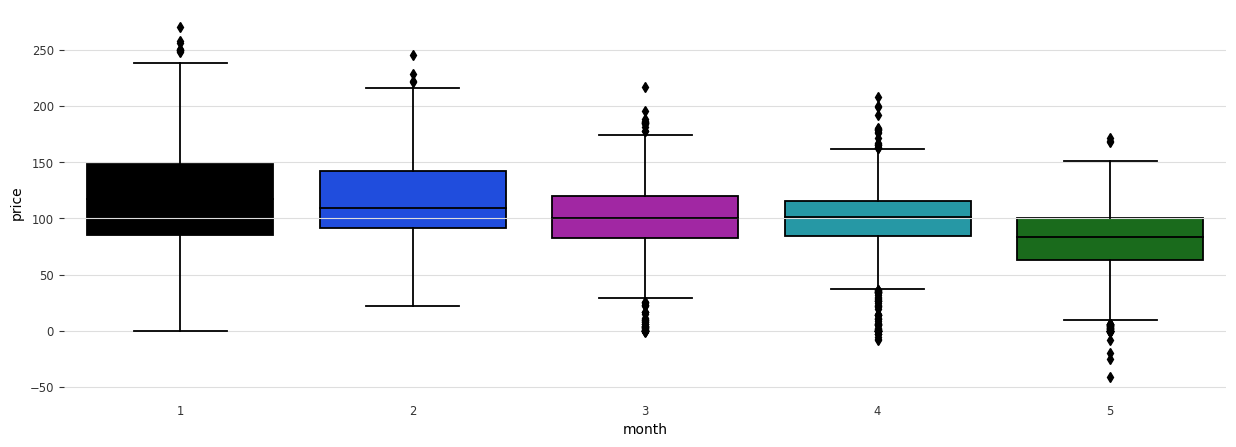

In [65]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='month', y='price')

<Axes: xlabel='day', ylabel='price'>

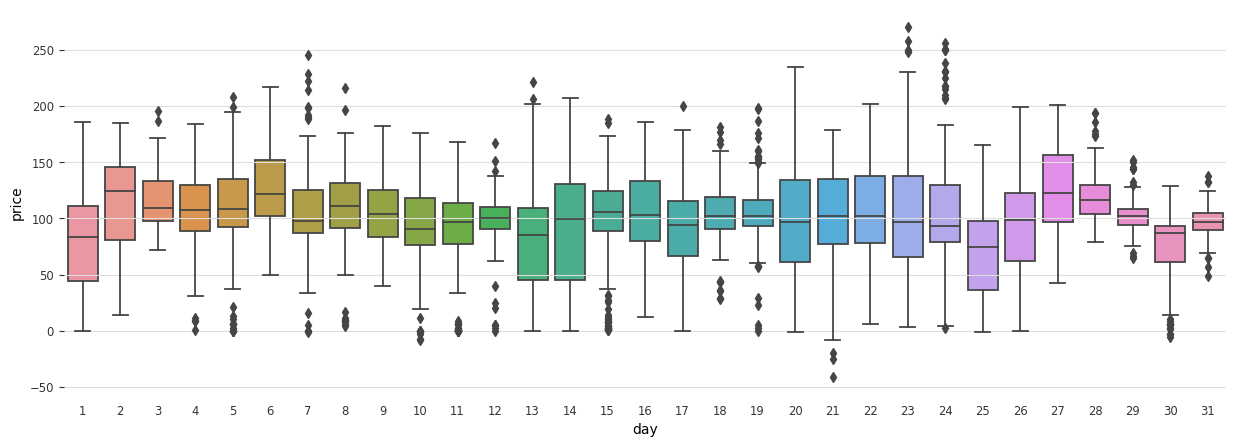

In [66]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='day', y='price')

<Axes: xlabel='hour', ylabel='price'>

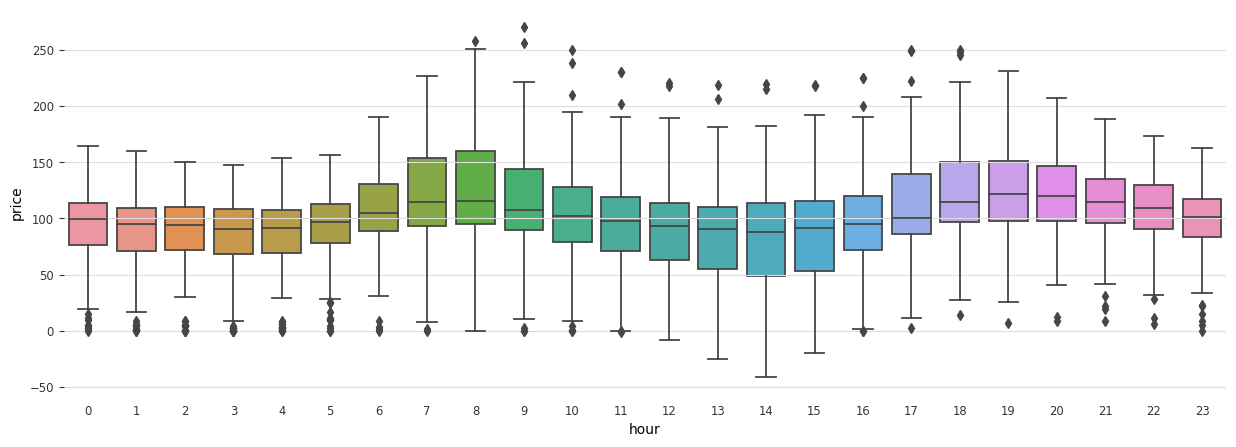

In [67]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='hour', y='price')

In [68]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True) 

df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

# split
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

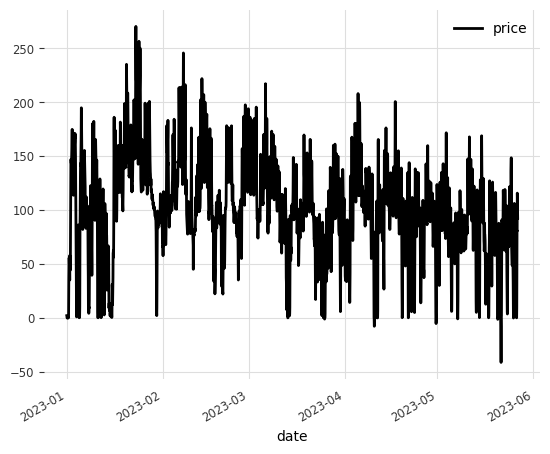

In [69]:
ts.plot()

##  Check the seasonality

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


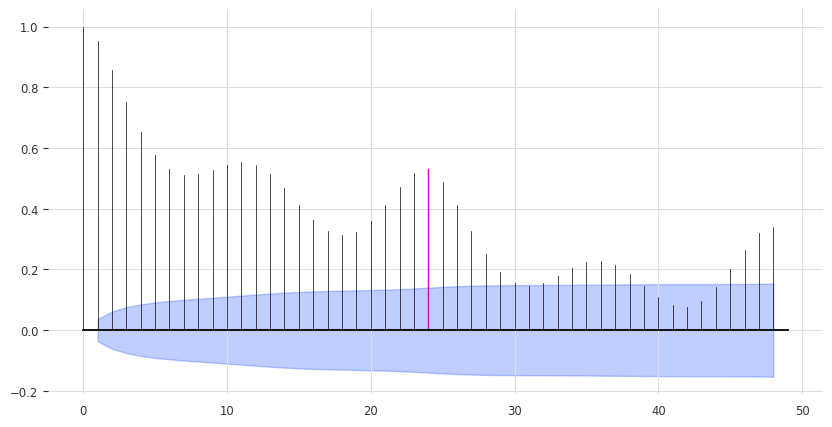

In [71]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(train, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


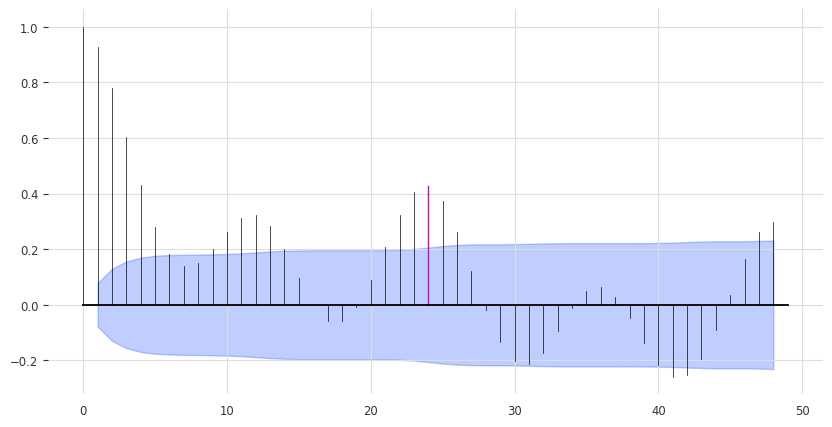

In [72]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(test, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(test, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


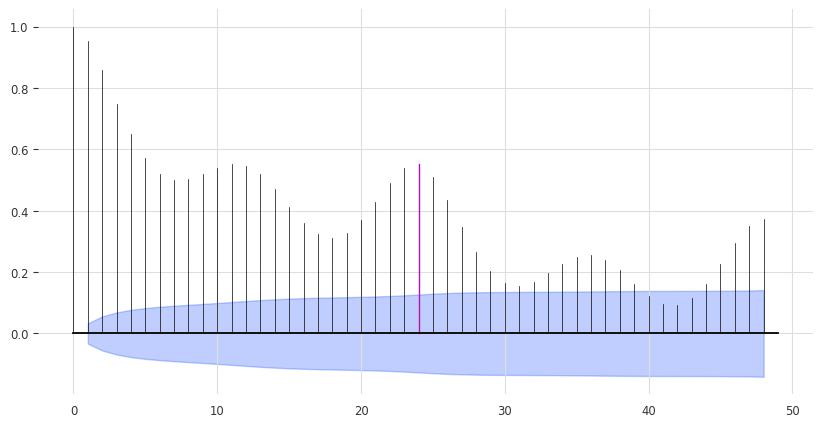

In [73]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(ts, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(ts, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))